# Max-min fairness

In this notebook, we evaluate the impact of splitting larger optimization problems into smaller sub-problems on policy runtime and quality of solution for max-min fairness policies.

## Import statements

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append("../../..")
from job_id_pair import JobIdPair
import utils
from plotting_utils import plot_runtimes, plot_effective_throughput_ratios
from plotting_utils import plot_runtime_vs_effective_throughput_ratios

import copy
import numpy as np
import random
import time

np.set_printoptions(precision=3, suppress=True)

## Harness that runs a policy with the passed-in number of sub-clusters

In [2]:
def create_problem_instance(num_jobs, cluster_spec,
                            policy_name,
                            seed,
                            introduce_skew=False):
    oracle_throughputs = utils.read_all_throughputs_json_v2("../../../simulation_throughputs.json")
    rng = random.Random()
    rng.seed(seed)
    jobs = {}
    throughputs = {}
    scale_factors = {}
    priority_weights = {}
    for i in range(num_jobs):
        job_id = JobIdPair(i, None)
        job = utils.generate_job(throughputs=oracle_throughputs,
                                 rng=rng, job_id=job_id)
        jobs[job_id[0]] = job
        job_type_key = (job.job_type, job.scale_factor)
        throughputs[job_id] = {}
        for worker_type in cluster_spec:
            throughputs[job_id][worker_type] = \
                oracle_throughputs[worker_type][job_type_key]['null']
        scale_factors[job_id] = 1
        if introduce_skew:
            priority_weights[job_id] = (i % 4) + 1.0
        else:
            priority_weights[job_id] = 1.0
    if 'pack' in policy_name:
        for i in range(num_jobs):
            job_type_key = (jobs[i].job_type, jobs[i].scale_factor)
            for j in range(num_jobs):
                if i < j and jobs[i].scale_factor == jobs[j].scale_factor:
                    other_job_type_key = \
                        (jobs[j].job_type, jobs[j].scale_factor)
                    throughputs[JobIdPair(i, j)] = {}
                    for worker_type in cluster_spec:
                        throughputs[JobIdPair(i, j)][worker_type] = \
                            oracle_throughputs[worker_type][job_type_key][other_job_type_key]
    return throughputs, scale_factors, priority_weights

In [3]:
def harness(policy, throughputs, scale_factors, priority_weights, cluster_spec, num_sub_clusters=1,
            random_cluster_assignment=False):
    start_time = time.time()
    sub_cluster_throughputs = []
    sub_cluster_scale_factors = []
    sub_cluster_priority_weights = []
    job_to_sub_cluster_assignment = {}
    job_ids = []
    for job_id in throughputs:
        if not job_id.is_pair():
            job_ids.append(job_id)
    for i, job_id in enumerate(job_ids):
        if random_cluster_assignment:
            job_to_sub_cluster_assignment[job_id[0]] = random.randint(0, num_sub_clusters-1)
        else:
            job_to_sub_cluster_assignment[job_id[0]] = job_id[0] % num_sub_clusters
    for i in range(num_sub_clusters):
        sub_cluster_throughputs.append({})
        sub_cluster_scale_factors.append({})
        sub_cluster_priority_weights.append({})
        for job_id in throughputs:
            if (job_to_sub_cluster_assignment[job_id[0]] == i) and (
                 not job_id.is_pair() or (job_to_sub_cluster_assignment[job_id[1]] == i)):
                sub_cluster_throughputs[-1][job_id] = copy.copy(throughputs[job_id])
                if not job_id.is_pair():
                    sub_cluster_scale_factors[-1][job_id] = scale_factors[job_id]
                    sub_cluster_priority_weights[-1][job_id] = priority_weights[job_id]
    sub_cluster_cluster_spec = {worker_type: cluster_spec[worker_type] // num_sub_clusters
                                for worker_type in cluster_spec}
    setup_time = time.time() - start_time
    full_allocation = {}
    computation_times = []
    for i in range(num_sub_clusters):
        start_time = time.time()
        if policy._name.startswith('MaxMinFairness'):
            sub_cluster_allocation = policy.get_allocation(
                sub_cluster_throughputs[i], sub_cluster_scale_factors[i],
                sub_cluster_priority_weights[i], sub_cluster_cluster_spec)
        else:
            sub_cluster_allocation = policy.get_allocation(
                sub_cluster_throughputs[i], sub_cluster_scale_factors[i],
                sub_cluster_cluster_spec)
        for job_id in sub_cluster_allocation:
            full_allocation[job_id] = sub_cluster_allocation[job_id]
        computation_times.append(time.time() - start_time)
    return full_allocation, setup_time + max(computation_times)

In [4]:
def sweep(policy_names_and_num_sub_clusters,
          all_num_jobs,
          num_trials, introduce_skew=False, solver='ECOS'):
    all_runtimes = {}
    all_effective_throughputs = {}
    for num_jobs in all_num_jobs:
        all_runtimes[num_jobs] = []
        all_effective_throughputs[num_jobs] = []
        cluster_spec = {
            'v100': max(num_jobs // 4, 1),
            'p100': max(num_jobs // 4, 1),
            'k80': max(num_jobs // 4, 1),
        }
        for i in range(num_trials):
            throughputs, scale_factors, priority_weights = \
                create_problem_instance(num_jobs, cluster_spec,
                                        policy_names_and_num_sub_clusters[0][0], seed=i,
                                        introduce_skew=introduce_skew)
            all_runtimes[num_jobs].append([])
            allocations = []
            for (policy_name, num_sub_clusters) in policy_names_and_num_sub_clusters:
                policy = utils.get_policy(policy_name, solver=solver)
                allocation, runtime = harness(
                    policy, throughputs,
                    scale_factors,
                    priority_weights,
                    cluster_spec,
                    num_sub_clusters=num_sub_clusters)
                all_runtimes[num_jobs][-1].append(runtime)
                allocations.append(allocation)

            all_effective_throughputs[num_jobs].append([])
            for allocation in allocations:
                effective_throughputs = {}
                for job_id in allocation:
                    for single_job_id in job_id.singletons():
                        if single_job_id not in effective_throughputs:
                            effective_throughputs[single_job_id] = 0.0
                    for worker_type in allocation[job_id]:
                        if job_id.is_pair():
                            for i, single_job_id in enumerate(job_id.singletons()):
                                effective_throughputs[single_job_id] += (
                                   allocation[job_id][worker_type] *
                                   throughputs[job_id][worker_type][i]
                                )
                        else:
                            effective_throughputs[job_id] += (
                                allocation[job_id][worker_type] *
                                throughputs[job_id][worker_type])
                all_effective_throughputs[num_jobs][-1].append(effective_throughputs)
    return all_runtimes, all_effective_throughputs

## Effective throughputs and runtimes

In [30]:
def get_runtimes_and_effective_throughputs(policy_name, all_num_sub_clusters,
                                           num_jobs, introduce_skew=False,
                                           solver='ECOS'):
    policy_names_and_num_sub_clusters = [
        (policy_name, num_sub_clusters)
        for num_sub_clusters in all_num_sub_clusters
    ]
    if not introduce_skew:
        policy_names_and_num_sub_clusters.append(
            ('gandiva', 1))
    all_runtimes, all_effective_throughputs = sweep(
        policy_names_and_num_sub_clusters, [num_jobs],
        num_trials=1, introduce_skew=introduce_skew, solver=solver)
    runtimes = all_runtimes[num_jobs][0]
    all_effective_throughputs = all_effective_throughputs[num_jobs][0]
    return runtimes, all_effective_throughputs

Original 1837.2635431289673 1.0 0.0
POP-2 173.74952745437622 0.9993083144477002 0.007878515437563764
POP-4 24.622868061065674 0.9990209858423391 0.009294896128721591
POP-8 4.530709981918335 0.9972380158914118 0.014228200752617187
Gandiva 68.3949043750763 0.5257595150336349 0.1640541553053958


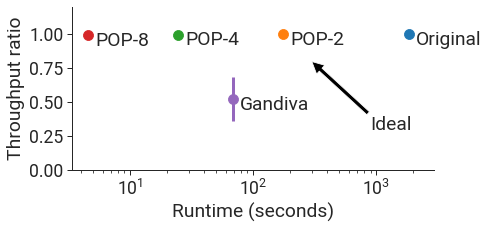

In [6]:
import ast
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
with open('num_jobs=1024.out', 'r') as f:
    runtimes = f.readline().strip()
    runtimes = ast.literal_eval(runtimes)
    all_effective_throughputs = f.readline().strip()
    all_effective_throughputs = ast.literal_eval(all_effective_throughputs)

plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    draw_arrow=True,
    output_filename="effective_throughput_ratio_and_runtimes/num_jobs=1024.pdf")

                                     CVXPY                                     
                                    v1.1.10                                    
(CVXPY) Mar 04 04:54:35 PM: Your problem has 1574400 variables, 3 constraints, and 0 parameters.
(CVXPY) Mar 04 04:54:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 04 04:54:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 04 04:54:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 04 04:54:35 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 04 04:54:35 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : LO (linear optimization problem)
  Constraints            : 393985          
  Cones                  : 0               
  Scalar variables       : 395011          
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : LO (linear optimization problem)
  Constraints            : 393985          
  Cones                  : 0               
  Scalar variables       : 395011          
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 4               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 1027
Optimizer  - Cones                  : 0
Optimizer  - Scalar variables   

8   4.0e-01  4.5e+04  3.6e-01  1.11e+00   -1.115634839e+00  -1.115604116e+00  5.9e+00  1.87  
9   1.8e-01  2.1e+04  1.6e-01  1.02e+00   -1.118437305e+00  -1.118422352e+00  2.7e+00  2.00  
10  3.7e-02  4.2e+03  3.3e-02  1.01e+00   -1.121479698e+00  -1.121476175e+00  5.4e-01  2.10  
11  1.6e-03  1.8e+02  1.4e-03  9.97e-01   -1.122125307e+00  -1.122125105e+00  2.3e-02  2.20  
12  8.2e-05  9.3e+00  7.2e-05  1.00e+00   -1.122141419e+00  -1.122141409e+00  1.2e-03  2.30  
13  1.0e-06  1.2e-01  3.4e-06  1.00e+00   -1.122143400e+00  -1.122143400e+00  1.5e-05  2.37  
14  1.0e-06  1.2e-01  3.4e-06  1.03e+00   -1.122143400e+00  -1.122143400e+00  1.5e-05  2.46  
15  5.3e-09  6.3e-04  1.7e-08  1.00e+00   -1.122143433e+00  -1.122143433e+00  7.8e-08  2.63  
Optimizer terminated. Time: 2.76    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: -1.1221434330e+00   nrm: 1e+00    Viol.  con: 1e-12    var: 7e-13  
  Dual.    obj: -1.1

(CVXPY) Mar 04 04:55:26 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Mar 04 04:55:26 PM: Applying reduction FlipObjective
(CVXPY) Mar 04 04:55:26 PM: Applying reduction Dcp2Cone
(CVXPY) Mar 04 04:55:26 PM: Applying reduction CvxAttr2Constr
(CVXPY) Mar 04 04:55:26 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Mar 04 04:55:26 PM: Applying reduction MOSEK
(CVXPY) Mar 04 04:55:26 PM: Finished problem compilation (took 3.426e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Mar 04 04:55:26 PM: Invoking solver MOSEK to obtain a solution.


Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : LO (linear optimization problem)
  Constraints            : 98

0   1.3e+01  3.8e+05  1.2e+01  0.00e+00   0.000000000e+00   0.000000000e+00   1.4e+02  0.17  
1   9.8e+00  2.8e+05  8.7e+00  1.77e+01   -7.554616817e-01  -6.391140680e-01  1.0e+02  0.20  
2   9.4e+00  2.7e+05  8.4e+00  6.47e+00   -8.118043562e-01  -7.767271479e-01  9.8e+01  0.23  
3   6.4e+00  1.8e+05  5.7e+00  9.87e+00   -8.758943676e-01  -8.701261568e-01  6.7e+01  0.25  
4   2.7e+00  7.5e+04  2.4e+00  4.27e+00   -9.881708569e-01  -9.870867084e-01  2.8e+01  0.27  
5   1.8e+00  5.2e+04  1.6e+00  1.53e+00   -1.037685581e+00  -1.036958915e+00  1.9e+01  0.29  
6   9.7e-01  2.8e+04  8.6e-01  1.39e+00   -1.068179545e+00  -1.067828896e+00  1.0e+01  0.31  
7   4.4e-01  1.2e+04  3.9e-01  1.18e+00   -1.084884025e+00  -1.084732563e+00  4.6e+00  0.33  
8   8.7e-02  2.5e+03  7.7e-02  1.07e+00   -1.095040596e+00  -1.095010992e+00  9.1e-01  0.35  
9   2.0e-02  5.5e+02  1.7e-02  1.02e+00   -1.096457968e+00  -1.096451306e+00  2.0e-01  0.37  
10  1.6e-03  4.6e+01  1.4e-03  9.83e-01   -1.096788328e+00  

(CVXPY) Mar 04 04:55:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 04 04:55:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 04 04:55:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 04 04:55:32 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 04 04:55:32 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Mar 04 04:55:32 PM: Applying reduction FlipObjective
(CVXPY) Mar 04 04:55:32 PM: Applying reduction Dcp2Cone
(CVXPY) Mar 04 04:55:32 PM: Applying reduction CvxAttr2Constr
(CVXPY) Mar 04 04:55:32 PM: Applying reduction C

Optimizer  - Semi-definite variables: 0                 scalarized             : 0               
Factor     - setup time             : 0.01              dense det. time        : 0.00            
Factor     - ML order time          : 0.00              GP order time          : 0.00            
Factor     - nonzeros before factor : 3.30e+04          after factor           : 3.37e+04        
Factor     - dense dim.             : 0                 flops                  : 6.54e+06        
ITE PFEAS    DFEAS    GFEAS    PRSTATUS   POBJ              DOBJ              MU       TIME  
0   9.5e+00  6.7e+04  8.4e+00  0.00e+00   0.000000000e+00   0.000000000e+00   7.0e+01  0.04  
1   7.1e+00  5.0e+04  6.3e+00  1.65e+01   -7.519577235e-01  -6.407923417e-01  5.3e+01  0.05  
2   6.7e+00  4.7e+04  6.0e+00  6.65e+00   -8.232262382e-01  -7.823517455e-01  5.0e+01  0.06  
3   5.7e+00  4.0e+04  5.0e+00  7.34e+00   -8.476481252e-01  -8.152703001e-01  4.2e+01  0.07  
4   3.1e+00  2.2e+04  2.8e+00  1.23e+01 

  Dual.    obj: -1.1040747303e+00   nrm: 1e+01    Viol.  con: 0e+00    var: 4e-09  
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Mar 04 04:55:33 PM: Problem status: optimal
(CVXPY) Mar 04 04:55:33 PM: Optimal value: 1.104e+00
(CVXPY) Mar 04 04:55:33 PM: Compilation took 8.238e-02 seconds
(CVXPY) Mar 04 04:55:33 PM: Solver (including time spent in interface) took 2.405e-01 seconds
                                     CVXPY                                     
                                    v1.1.10                                    
(CVXPY) Mar 04 04:55:34 PM: Your problem has 24768 variables, 3 constraints, and 0 parameters.
(CVXPY) Mar 04 04:55:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 04 04:55:34 PM: (If you need to solve this problem multiple time



Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : LO (linear optimization problem)
  Constraints            : 24769           
  Cones                  : 0               
  Scalar variables       : 25027           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : LO (linear optimization problem)
  Constraints            : 24769           
  Cones                  : 0               
  Scalar variables       : 25027           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 4               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 259
Optimizer  - Cones                  : 0
Optimizer  - Scalar variables    

10  2.3e-03  1.6e+01  2.0e-03  9.95e-01   -1.109112581e+00  -1.109110213e+00  1.7e-02  0.12  
11  2.9e-04  2.0e+00  2.5e-04  1.00e+00   -1.109162929e+00  -1.109162633e+00  2.1e-03  0.13  
12  1.3e-05  9.0e-02  7.9e-06  1.00e+00   -1.109152002e+00  -1.109151992e+00  9.4e-05  0.14  
13  8.0e-08  5.7e-04  5.6e-06  1.00e+00   -1.109151965e+00  -1.109151958e+00  5.9e-07  0.15  
14  4.1e-10  3.8e-06  3.1e-06  1.00e+00   -1.109151964e+00  -1.109151960e+00  3.1e-09  0.15  
Optimizer terminated. Time: 0.17    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: -1.1091519640e+00   nrm: 1e+00    Viol.  con: 8e-13    var: 4e-13  
  Dual.    obj: -1.1091519604e+00   nrm: 7e+00    Viol.  con: 0e+00    var: 3e-09  
-------------------------------------------------------------------------------
                                    Summary                                    
----------------------------------------------------------

(CVXPY) Mar 04 04:55:35 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Mar 04 04:55:35 PM: Applying reduction FlipObjective
(CVXPY) Mar 04 04:55:35 PM: Applying reduction Dcp2Cone
(CVXPY) Mar 04 04:55:35 PM: Applying reduction CvxAttr2Constr
(CVXPY) Mar 04 04:55:35 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Mar 04 04:55:35 PM: Applying reduction MOSEK
(CVXPY) Mar 04 04:55:35 PM: Finished problem compilation (took 8.278e-02 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Mar 04 04:55:36 PM: Invoking solver MOSEK to obtain a solution.


Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : LO (linear optimization problem)
  Constraints            : 24

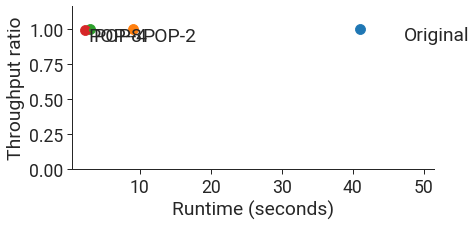

In [52]:
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
#all_num_sub_clusters = [1]

import cvxpy as cp
runtimes, all_effective_throughputs = \
    get_runtimes_and_effective_throughputs('max_min_fairness_packed',
                                           all_num_sub_clusters,
                                           1024, solver='MOSEK')

plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    output_filename="effective_throughput_ratio_and_runtimes/num_jobs=256.pdf")

In [13]:
all_effective_throughputs

[{0: 1461.0810523132425,
  1: 16396.57405313227,
  2: 7996.443685863115,
  3: 52151.58459594826,
  4: 11662.382894057013,
  5: 5757.09029191739,
  6: 56294.8334300607,
  7: 7996.443685863115,
  8: 1461.0810523132425,
  9: 39840.48487177246,
  10: 21013.06225364291,
  11: 12826.72248118965,
  12: 7996.443685863115,
  13: 13839.625139474416,
  14: 12826.72248118965,
  15: 16396.57405313227,
  16: 56294.8334300607,
  17: 16396.57405313227,
  18: 35040.09926408314,
  19: 51684.03327003482,
  20: 39840.48487177246,
  21: 51684.03327003482,
  22: 56294.8334300607,
  23: 79575.79976749202,
  24: 35040.09926408314,
  25: 100126.65316774067,
  26: 4108.063833553534,
  27: 35040.09926408314,
  28: 5757.09029191739,
  29: 12209.82270732292,
  30: 13839.625139474416,
  31: 35407.91629479477,
  32: 56282.109954878986,
  33: 25251.34797897468,
  34: 51684.03327003482,
  35: 11662.382894057013,
  36: 21013.06225364291,
  37: 1461.0810523132425,
  38: 2067.542784741084,
  39: 25251.34797897468,
  40: 

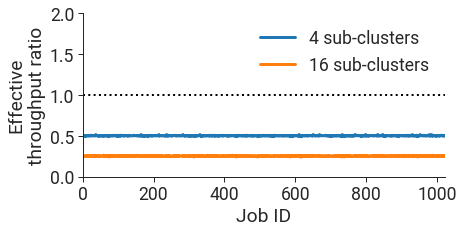

In [25]:
from plotting_utils import plot_runtimes, plot_effective_throughput_ratios

plot_effective_throughput_ratios(all_effective_throughputs)

Original 1.8602049350738525 1.0 0.0
POP-2 0.4788846969604492 0.9980712142190336 0.012912759998481516
POP-4 0.1800069808959961 0.994742041845257 0.012014975054153193
POP-8 0.16145968437194824 0.9887680642914478 0.013825948504964916


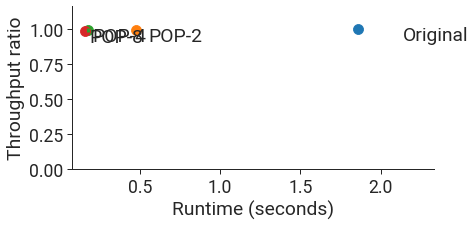

In [50]:
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
#all_num_sub_clusters = [1]

runtimes, all_effective_throughputs_256 = \
    get_runtimes_and_effective_throughputs('max_min_fairness_packed',
                                           all_num_sub_clusters,
                                           256, solver='MOSEK')

plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs_256, labels,
    output_filename="effective_throughput_ratio_and_runtimes/num_jobs=256.pdf")

Original 1.6612496376037598 1.0 0.0
POP-2 0.46480655670166016 0.9980712142190336 0.012912759998481516
POP-4 0.17132210731506348 0.994742041845257 0.012014975054153193
POP-8 0.3393869400024414 0.9887680642914478 0.013825948504964916


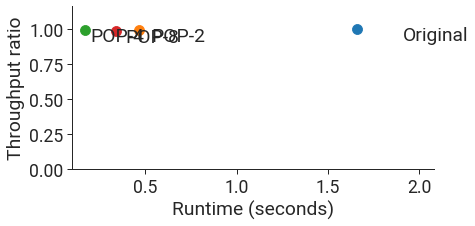

In [49]:
plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs_256, labels,
    output_filename="effective_throughput_ratio_and_runtimes/num_jobs=256.pdf")

In [ ]:
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
runtimes, all_effective_throughputs = \
    get_runtimes_and_effective_throughputs('max_min_fairness_packed',
                                           all_num_sub_clusters,
                                           256,
                                           introduce_skew=True)
plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    output_filename="effective_throughput_ratio_and_runtimes/skewed_num_jobs=256.pdf")

In [ ]:
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
runtimes, all_effective_throughputs = \
    get_runtimes_and_effective_throughputs('max_min_fairness_packed',
                                           all_num_sub_clusters,
                                           512)
plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    output_filename="effective_throughput_ratio_and_runtimes/num_jobs=512.pdf")

In [ ]:
labels = ['Original', 'POP-2', 'POP-4', 'POP-8', 'Gandiva']
all_num_sub_clusters = [1, 2, 4, 8]
runtimes, all_effective_throughputs = \
    get_runtimes_and_effective_throughputs('max_min_fairness_packed',
                                           all_num_sub_clusters,
                                           512,
                                           introduce_skew=True)
plot_runtime_vs_effective_throughput_ratios(
    runtimes, all_effective_throughputs, labels,
    output_filename="effective_throughput_ratio_and_runtimes/skewed_num_jobs=512.pdf")

## Runtimes

In [10]:
def get_runtimes(policy_name, all_num_jobs, introduce_skew=False):
    data = {
        'policy': [],
        'num_jobs': [],
        'runtimes': []
    }
    all_num_sub_clusters = [1, 4, 16]
    policy_names_and_num_sub_clusters = [
        (policy_name, num_sub_clusters)
        for num_sub_clusters in all_num_sub_clusters
    ]
    policy_labels = ['Vanilla', '4 sub-clusters', '16 sub-clusters']
    all_runtimes, _ = sweep(policy_names_and_num_sub_clusters,
                            all_num_jobs,
                            num_trials=1,
                            introduce_skew=introduce_skew)
    for num_jobs in all_runtimes:
        for i in range(len(all_runtimes[num_jobs])):
            for (policy_label, runtime) in zip(
                policy_labels, all_runtimes[num_jobs][i]):
                data['policy'].append(policy_label)
                data['num_jobs'].append(num_jobs)
                data['runtimes'].append(runtime)
    return data

In [13]:
all_num_jobs = [64, 128, 256, 512, 1024, 2048,
                4096, 8192, 16384, 32768]
xticks = [64, 512, 4096, 32768]
yticks = [2**-8, 2**-5, 2**-2, 2**1, 2**4, 2**7]
yticklabels = [0.004, 0.031, 0.25, 2, 16, 128]
plot_runtimes(get_runtimes('max_min_fairness_perf',
                           all_num_jobs=all_num_jobs,
                           introduce_skew=False),
              xticks=xticks, yticks=yticks,
              yticklabels=yticklabels,
              output_filename="runtimes/max_min_fairness_perf.pdf")
plot_runtimes(get_runtimes('max_min_fairness_perf',
                           all_num_jobs=all_num_jobs,
                           introduce_skew=True),
              xticks=xticks, yticks=yticks,
              yticklabels=yticklabels)

Failure:Interrupted


SolverError: Solver 'SCS' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
# TODO: Increase to 1024.
all_num_jobs=[64, 128, 256, 512]
xticks = [64, 128, 256, 512]
yticks = [2**-5, 2**-2, 2**1, 2**4, 2**7]
yticklabels = [0.031, 0.25, 2, 16, 128]
plot_runtimes(get_runtimes('max_min_fairness_packed',
                           all_num_jobs=all_num_jobs,
                           introduce_skew=False),
              xticks=xticks, yticks=yticks,
              yticklabels=yticklabels,
              output_filename="runtimes/max_min_fairness_packed.pdf")
plot_runtimes(get_runtimes('max_min_fairness_packed',
                           all_num_jobs=all_num_jobs,
                           introduce_skew=True),
              xticks=xticks, yticks=yticks,
              yticklabels=yticklabels)

## Effective throughput ratios

In [ ]:
def get_effective_throughput_ratios(policy_name, num_jobs, introduce_skew=False,
                                    random_cluster_assignment=False):
    random.seed(42)
    all_num_sub_clusters = [1, 4, 16]
    policy_names_and_num_sub_clusters = [
        (policy_name, num_sub_clusters)
        for num_sub_clusters in all_num_sub_clusters
    ]
    _, all_effective_throughputs = sweep(
        policy_names_and_num_sub_clusters,
        [num_jobs],
        num_trials=1,
        introduce_skew=introduce_skew)
    return all_effective_throughputs[num_jobs][0]

In [ ]:
print("No skew")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_perf', 64),
    output_filename="effective_throughput_ratios/max_min_fairness_perf.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_perf', 64),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_perf_cdf.pdf")
print("Skew and round-robin placement")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_perf', 64,
        introduce_skew=True),
    output_filename="effective_throughput_ratios/max_min_fairness_perf_skewed.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios('max_min_fairness_perf', 64,
                                    introduce_skew=True),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_perf_skewed_cdf.pdf")
print("Skew and random placement")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios('max_min_fairness_perf', 64,
                                    introduce_skew=True,
                                    random_cluster_assignment=True),
    output_filename="effective_throughput_ratios/max_min_fairness_perf_skewed_random.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios('max_min_fairness_perf', 64,
                                    introduce_skew=True,
                                    random_cluster_assignment=True),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_perf_skewed_random_cdf.pdf")

In [ ]:
print("No skew")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64),
    output_filename="effective_throughput_ratios/max_min_fairness_packed.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_packed_cdf.pdf")
print("Skew and round-robin placement")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64,
    introduce_skew=True),
    output_filename="effective_throughput_ratios/max_min_fairness_packed_skewed.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64,
        introduce_skew=True),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_packed_skewed_cdf.pdf")
print("Skew and random placement")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64,
         introduce_skew=True,
    random_cluster_assignment=True),
    output_filename="effective_throughput_ratios/max_min_fairness_packed_skewed_random.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        'max_min_fairness_packed', 64,
        introduce_skew=True,
        random_cluster_assignment=True),
    cdf=True,
    output_filename="effective_throughput_ratios/max_min_fairness_packed_skewed_random_cdf.pdf")